# Performance

[Wes McKinney](https://twitter.com/wesmckinn), the creator of pandas, is kind of obsessed with performance. From micro-optimizations for element access, to [embedding](https://github.com/pydata/pandas/tree/master/pandas/src/klib) a fast hashtable data structure inside pandas, we benefit from all his hard work.

One thing I'm not really going to touch on is storage formats.
There's too many other factors that go into the decision of what format to use for me to spend much time talking exclusively about performance. Just know that pandas can talk to [many formats](http://pandas.pydata.org/pandas-docs/version/0.18.0/io.html), and the format that strikes the right balance between performance, portability, data-types, metadata handling, etc., is an [ongoing](http://blog.cloudera.com/blog/2016/03/feather-a-fast-on-disk-format-for-data-frames-for-r-and-python-powered-by-apache-arrow/) topic of discussion.

## Constructors

It's pretty common to have many similar souces (say a bunch of CSVs) that need to be combined into a single DataFrame. There are two routes to the same end

1. Initialze one DataFrame and append to that
2. Make many smaller DataFrames and concatenate at the end

For pandas, the second option is faster.
DataFrame appends are expensive relative to a list append.
Depending on the values, you may have to be recast data to a different type.
And indexes are immutable, so each time you append pandas has to create an entirely new one.

In the last section we download a bunch of weather files, one per state, writing each to a separate CSV. One could imagine coming back later to read them in, using the following code.

The idiomatic python way

```python
files = glob.glob('weather/*.csv')
columns = ['station', 'date', 'tmpf', 'relh', 'sped', 'mslp',
           'p01i', 'vsby', 'gust_mph', 'skyc1', 'skyc2', 'skyc3']

# init empty DataFrame, like you might for a list
weather = pd.DataFrame(columns=columns)

for fp in files:
    city = pd.read_csv(fp, columns=columns)
    weather.append(df)
```

This is pretty standard code, quite similar to building up a list of tuples, say.
The only nitpick is that you'd probably use a list-comprehension if you were just making a list. But we don't have special syntax for DataFrame-comprehensions (if only), so you'd fall back to the "intitilize empty container, append to said container" pattern.

But, there's a better, pandorable, way

```python
files = glob.glob('weather/*.csv')
weather_dfs = [pd.read_csv(fp, names=columns) for fp in files]
weather = pd.concat(weather_dfs)
```

Subjectively this is cleaner and more beautiful.
There's fewer lines of code.
You don't have this extreaneous detail of building an empty DataFrame.
And objectively the pandorable way is faster, as we'll test next.

We'll define two functions for building an identical DataFrame. The first `append_df`, creates an empty dataframe and appends to it. The second, `concat_df`,  creates many DataFrames, and concatenates them at the end. We also write a short decorator that runs the functions a handful of times and records the results.

In [1]:
import time

size_per = 5000
N = 100
cols = list('abcd')

def timed(n=30):
    '''
    Running a microbenchmark. Never use this.
    '''
    def deco(func):
        def wrapper(*args, **kwargs):
            timings = []
            for i in range(n):
                t0 = time.time()
                func(*args, **kwargs)
                t1 = time.time()
                timings.append(t1 - t0)
            return timings
        return wrapper
    return deco
    
@timed(60)
def append_df():
    '''
    The pythonic (bad) way
    '''
    df = pd.DataFrame(columns=cols)
    for _ in range(N):
        df.append(pd.DataFrame(np.random.randn(size_per, 4), columns=cols))
    return df

@timed(60)
def concat_df():
    '''
    The pandorabe (good) way
    '''
    dfs = [pd.DataFrame(np.random.randn(size_per, 4), columns=cols)
           for _ in range(N)]
    return pd.concat(dfs, ignore_index=True)

In [2]:
t_append = append_df()
t_concat = concat_df()

timings = (pd.DataFrame({"Append": t_append, "Concat": t_concat})
             .stack()
             .reset_index()
             .rename(columns={0: 'Time (s)',
                              'level_1': 'Method'}))
timings.head()

,level_0,Method,Time (s)
0,0,Append,0.166875
1,0,Concat,0.111531
2,1,Append,0.162549
3,1,Concat,0.097985
4,2,Append,0.166977


In [3]:
%matplotlib inline

sns.set_style('ticks')
sns.set_context('talk')

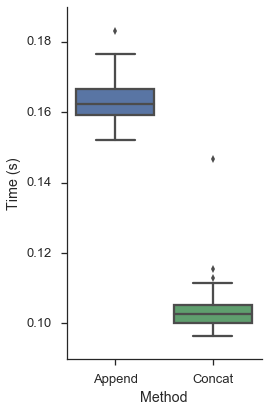

In [4]:
plt.figure(figsize=(4, 6))
sns.boxplot(x='Method', y='Time (s)', data=timings)
sns.despine()
plt.tight_layout()

# Avoid `object` dtypes where possible

The pandas type system esentially NumPy's with a few extensions (`categorical`, `datetime64`, `timedelta64`). An advantage of a DataFrame over a 2-dimensional NumPy array is that the DataFrame can have columns of various types within a single table. That said, each column should have a specific dtype; you don't want to be mixing bools with ints with strings within a single column. For one thing, this is slow. It forces the column to be have an `object` dtype (the fallback container type), which means you don't get any of the type-specific optimizations in pandas. For another, it violates the maxims of tidy data.

When should you have `object` columns?
There are a few places where the NumPy / pandas type system isn't as rich as you might like. There's no integer NA, so if you have any missing values, represented by `NaN`, your otherwise integer column will be floats.
There's also no `date` dtype (distinct from `datetime`).
Consider the needs of your application: can you treat an integer `1` as `1.0`?
Can you treat `date(2016, 1, 1)` as `datetime(2016, 1, 1, 0, 0)`?
In my experience, this is rarely a problem other than when writing to something with a stricter schema like a database.
But at that point it's fine to cast to one of the less performant types, since you're just not doing any operations any more.

The last case of `object` dtype data is text data.
Pandas doesn't have any fixed-width string dtypes, so you're stuck with python objects.
There is an important exception here, and that's low-cardinality text data, which is great for Categoricals (see below).

# Iteration, Apply, And Vectorization

We know that ["Python is slow"](https://jakevdp.github.io/blog/2014/05/09/why-python-is-slow/) (scare  quotes since that statement is too broad to be meaningful). There are various steps that can be taken to improve your code's performance from relatively simple changes, to rewriting your code in a lower-level language or trying to parallelize it.
And while you might have many options, there's typically an order you would proceed in.

First (and I know it's cliche to say so, but still) benchmark your code. Make sure you actual need to spend time optimizing it. There are [many](https://github.com/nvdv/vprof) [options](https://jiffyclub.github.io/snakeviz/) [for](https://github.com/rkern/line_profiler) [benchmarking](https://docs.python.org/3.5/library/timeit.html) and visualizing where things are slow.

Second, consider your algorithm. Make sure you aren't doing more work than you need to. A common one I see is doing a full sort on an array, just to select the `N` largest or smallest items. Pandas has methods for that.

In [5]:
df = pd.read_csv("878167309_T_ONTIME.csv")
delays = df['DEP_DELAY']

In [6]:
# Select the 5 largest delays
delays.nlargest(5).sort_values()

62914     1461.0
455195    1482.0
215520    1496.0
454520    1500.0
271107    1560.0
Name: DEP_DELAY, dtype: float64

In [7]:
delays.nsmallest(5).sort_values()

307517   -112.0
39907     -85.0
44336     -46.0
78042     -44.0
27749     -42.0
Name: DEP_DELAY, dtype: float64

We follow up the `nlargest` or `nsmallest` with a sort (the result of `nlargest/smallest` is unordered), but it's much easier to sort 5 items that 500,000. The timings bear this out:

In [8]:
%timeit delays.sort_values().tail(5)

10 loops, best of 3: 60.4 ms per loop


In [9]:
%timeit delays.nlargest(5).sort_values()

100 loops, best of 3: 12 ms per loop


Assuming you're at a spot that needs optimizing, and you've got the correct algorithm, *and* there isn't a readily available optimized version of what you need in pandas/numpy/scipy/scikit-learn/statsmodels/..., then what?

The first place to turn is probably a vectorized NumPy implmentation.
Vectorization here means operating on arrays, rather than scalars.
This is generally much less work than rewriting it with something like Cython, and you can get pretty good results just by making *effective* use of NumPy and pandas.
Not all operations are amenable to vectorization, but many are.

Let's work through an example calculating the [Great-circle distance](https://en.wikipedia.org/wiki/Great-circle_distance) between airports.
Grab the table of airport latitudes and longitudes from the [BTS website](http://www.transtats.bts.gov/DL_SelectFields.asp?Table_ID=288&DB_Short_Name=Aviation%20Support%20Tables) and extract it to a CSV.

In [10]:
coord = (pd.read_csv("227597776_T_MASTER_CORD.csv", index_col=['AIRPORT'])
           .query("AIRPORT_IS_LATEST == 1")[['LATITUDE', 'LONGITUDE']]
           .dropna()
           .sample(n=500, random_state=42)
           .sort_index())

coord.head()

,LATITUDE,LONGITUDE
AIRPORT,,
A03,58.457500,-154.023333
A12,60.785278,-158.864444
A21,65.851389,-164.702778
A27,64.440000,-144.936389
A43,57.780833,-152.391111


For whatever reason, suppose we're interested in all the pairwise distances (I've limited it to just a sample of 500 airports to make this managable. In the real world you *probably* don't need *all* the pairwise distances, and --since you know to pick the right algorithm before optimizing-- would be better off with a [tree](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KDTree.html)).

MultiIndexes have an alternative `from_product` constructor for getting the cartesian product of the arrays you pass in. We'll pass in the `coords.index` twice and do some index manipulation to get a DataFrame with all the pairwise combinations of latitudes and longitudes. This will be a bit wasteful since the distance from airport `A` to `B` is the same as `B` to `A`, but we'll ignore that for now.

In [11]:
idx = pd.MultiIndex.from_product([coord.index, coord.index],
                                 names=['origin', 'dest'])

pairs = pd.concat([coord.add_suffix('_1').reindex(idx, level='origin'),
                   coord.add_suffix('_2').reindex(idx, level='dest')],
                  axis=1)
pairs.head()

LATITUDE_1  LONGITUDE_1  LATITUDE_2  LONGITUDE_2
origin dest                                                  
A03    A03      58.4575  -154.023333   58.457500  -154.023333
       A12      58.4575  -154.023333   60.785278  -158.864444
       A21      58.4575  -154.023333   65.851389  -164.702778
       A27      58.4575  -154.023333   64.440000  -144.936389
       A43      58.4575  -154.023333   57.780833  -152.391111

In [12]:
idx = idx[idx.get_level_values(0) <= idx.get_level_values(1)]

In [13]:
len(idx)

125250

Breaking that down a bit:

The `add_suffix` (and `add_prefix`) is a handy method for quickly renaming the columns.

In [14]:
coord.add_suffix('_1').head()

,LATITUDE_1,LONGITUDE_1
AIRPORT,,
A03,58.457500,-154.023333
A12,60.785278,-158.864444
A21,65.851389,-164.702778
A27,64.440000,-144.936389
A43,57.780833,-152.391111


Alternatively you could use the more general `.rename` like `coord.rename(columns=lambda x: x + '_1')`.

Next, we have the reindex.
Like I mentioned last time, indexes are cruical to pandas.
`.reindex` is all about aligning a Series or DataFrame to a given index.
In this case we use `.reindex` to align our original DataFrame to the new
MultiIndex of combinations.
By default, the output will have the original value if that index label was already present, and `NaN` otherwise.
If we just called `coord.reindex(idx)`, with no additional arguments, we'd get a DataFrame of all `NaN`s.

In [15]:
coord.reindex(idx).head()

LATITUDE  LONGITUDE
origin dest                     
A03    A03        NaN        NaN
       A12        NaN        NaN
       A21        NaN        NaN
       A27        NaN        NaN
       A43        NaN        NaN

That's because there weren't any values of `idx` that were in `coord.index`,
which makes sense since `coord.index` is just a regular one-level Index, while `idx` is a MultiIndex.
We use the `level` keyword to handle the transition from the original single-level Index, to the two-leveled `idx`.

> `level` : int or name
>
    Broadcast across a level, matching Index values on the
    passed MultiIndex level

In [16]:
coord.reindex(idx, level='dest').head()

LATITUDE   LONGITUDE
origin dest                       
A03    A03   58.457500 -154.023333
       A12   60.785278 -158.864444
       A21   65.851389 -164.702778
       A27   64.440000 -144.936389
       A43   57.780833 -152.391111

If you ever need to do an operation that mixes regular single-level indexes with Multilevel Indexes, look for a level keyword argument. For example, all the math operations have them.

In [17]:
try:
    coord.mul(coord.reindex(idx, level='origin'))
except ValueError:
    print('ValueError: confused pandas')

ValueError: confused pandas


In [19]:
coord.mul(coord.reindex(idx, level='origin'),
          level='dest').head()

LATITUDE     LONGITUDE
origin dest                           
A03    A03   3417.279306  23723.187210
       A12   3553.355376  24468.831280
       A21   3849.507566  25368.070842
       A27   3767.001300  22323.585738
       A43   3377.723064  23471.786903

Tangent, I got some... pushback is too strong a word, let's say skepticism on my last piece about the value of indexes. Here's an alternative version for the skeptics

In [20]:
from itertools import product, chain
coord2 = coord.reset_index()

In [21]:
x = product(coord2.add_suffix('_1').itertuples(index=False),
            coord2.add_suffix('_2').itertuples(index=False))
y = [list(chain.from_iterable(z)) for z in x]

df2 = (pd.DataFrame(y, columns=['origin', 'LATITUDE_1', 'LONGITUDE_1',
                                'dest', 'LATITUDE_1', 'LONGITUDE_2'])
       .set_index(['origin', 'dest']))
df2.head()

LATITUDE_1  LONGITUDE_1  LATITUDE_1  LONGITUDE_2
origin dest                                                  
A03    A03      58.4575  -154.023333   58.457500  -154.023333
       A12      58.4575  -154.023333   60.785278  -158.864444
       A21      58.4575  -154.023333   65.851389  -164.702778
       A27      58.4575  -154.023333   64.440000  -144.936389
       A43      58.4575  -154.023333   57.780833  -152.391111

It's also readable (it's Python after all), though a bit slower.

With that diversion out of the way, let's turn back to our great-circle distance calculation.

Our first implementation is pure python.
The algorithm itself isn't too important, all that matters is that we're doing math operations on scalars.

In [22]:
import math

def gcd_py(lat1, lng1, lat2, lng2):
    '''
    Calculate great circle distance between two points.
    http://www.johndcook.com/blog/python_longitude_latitude/
    
    Parameters
    ----------
    lat1, lng1, lat2, lng2: float
    
    Returns
    -------
    distance:
      distance from ``(lat1, lng1)`` to ``(lat2, lng2)`` in kilometers.
    '''
    # python2 users will have to use ascii identifiers (or upgrade)
    degrees_to_radians = math.pi / 180.0
    ϕ1 = (90 - lat1) * degrees_to_radians
    ϕ2 = (90 - lat2) * degrees_to_radians
    
    θ1 = lng1 * degrees_to_radians
    θ2 = lng2 * degrees_to_radians
    
    cos = (math.sin(ϕ1) * math.sin(ϕ2) * math.cos(θ1 - θ2) +
           math.cos(ϕ1) * math.cos(ϕ2))
    # round to avoid precision issues on identical points causing ValueErrors
    cos = round(cos, 8)
    arc = math.acos(cos)
    return arc * 6373  # radius of earth, in kilometers

The second implementation uses NumPy. Note that aside from numpy having a builtin `deg2rad` convenience function (which is probably a bit slower than multiplying by a constant $\pi/180$ ), basically all we've done is swap the `math` prefix for `np`. Thanks to NumPy's broadcasting, we can write code that works on scalars or arrays of conformable shape.

In [23]:
def gcd_vec(lat1, lng1, lat2, lng2):
    '''
    Calculate great circle distance.
    http://www.johndcook.com/blog/python_longitude_latitude/
    
    Parameters
    ----------
    lat1, lng1, lat2, lng2: float or array of float
    
    Returns
    -------
    distance:
      distance from ``(lat1, lng1)`` to ``(lat2, lng2)`` in kilometers.
    '''
    # python2 users will have to use ascii identifiers
    ϕ1 = np.deg2rad(90 - lat1)
    ϕ2 = np.deg2rad(90 - lat2)
    
    θ1 = np.deg2rad(lng1)
    θ2 = np.deg2rad(lng2)
    
    cos = (np.sin(ϕ1) * np.sin(ϕ2) * np.cos(θ1 - θ2) +
           np.cos(ϕ1) * np.cos(ϕ2))
    arc = np.arccos(cos)
    return arc * 6373

To use the python version on our DataFrame, we can either iterate...

In [24]:
%%time
pd.Series([gcd_py(*x) for x in pairs.itertuples(index=False)],
          index=pairs.index)

CPU times: user 938 ms, sys: 12.4 ms, total: 950 ms
Wall time: 952 ms


origin  dest
A03     A03         0.000000
        A12       375.581448
        A21       989.197819
        A27       820.626078
        A43       121.894542
                    ...     
ZXX     ZMT      1262.373758
        ZNE     14222.583846
        ZNZ     15114.635597
        ZXK      1346.351439
        ZXX         0.000000
dtype: float64

Or use `DataFrame.apply`.

In [25]:
%%time
r = pairs.apply(lambda x: gcd_py(x['LATITUDE_1'], x['LONGITUDE_1'],
                                 x['LATITUDE_2'], x['LONGITUDE_2']), axis=1);

CPU times: user 18.7 s, sys: 78 ms, total: 18.8 s
Wall time: 18.8 s


But as you can see, you don't want to use apply, especially with `axis=1` (calling the function on each row).  It's doing a lot more work handling dtypes in the background, and trying to infer the correct output shape that are pure overhead in this case. On top of that, it has to essentially use a for loop internally.

You *rarely* want to use `DataFrame.apply` and almost never should use it with `axis=1`. Better to write functions that take arrays, and pass those in directly. Like we did with the vectorized version

In [26]:
%%time
r = gcd_vec(pairs['LATITUDE_1'], pairs['LONGITUDE_1'],
            pairs['LATITUDE_2'], pairs['LONGITUDE_2'])

CPU times: user 44 ms, sys: 12.6 ms, total: 56.5 ms
Wall time: 39.8 ms


In [27]:
r.head()

origin  dest
A03     A03       0.000000
        A12     375.581350
        A21     989.197915
        A27     820.626105
        A43     121.892994
dtype: float64

So about 30x faster, and more readable. I'll take it.

I try not to use the word "easy" when teaching, but that optimization was easy right?
The key was knowing about broadcasting, and seeing where to apply it (which is more difficult).
I have seen uses of `.apply(..., axis=1)` in my code and other's, even when the vectorized version is availble.

For example, the README for [lifetimes](https://github.com/CamDavidsonPilon/lifetimes) (by Cam Davidson Pilon, also author of [Bayesian Methods for Hackers](https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers), [lifelines](https://github.com/CamDavidsonPilon/lifelines), and [Data Origami](https://dataorigami.net)) used to have an example of passing [this method](https://github.com/CamDavidsonPilon/lifetimes/blob/5b4f7de0720413b6951ac0a4b0082bd50255a231/lifetimes/estimation.py#L249) into a `DataFrame.apply`.

```python
data.apply(lambda r: bgf.conditional_expected_number_of_purchases_up_to_time(
    t, r['frequency'], r['recency'], r['T']), axis=1
)
```

If you look at the function I linked to, it's doing a fairly complicated computation involving a negative log likelihood and the Gamma function from `scipy.special`. But crucially, it was already vectorized. We were able to change the example to just pass the arrays (Series in this case) into the function, rather than applying the function to each row.
This got us another 30x speedup on the example dataset.

```python
bgf.conditional_expected_number_of_purchases_up_to_time(
    t, data['frequency'], data['recency'], data['T']
)
```

I bring this up because it's very natural to have to translate an equation to code and think, "Ok now I need to apply this function to each row", so you reach for `DataFrame.apply`. See if you can just pass in the NumPy array or Series itself instead.

Not all operations this easy to vectorize.
Some operations are iterative by nature, and rely on the results of surrounding computations to procede. In cases like this you can hope that one of the scientific python libraries has implemented it efficiently for you, or write your own solution using Numba / C / Cython / Fortran.

Other examples take a bit more thought to vectorize. Let's look at [this](http://nbviewer.jupyter.org/github/jreback/pydata2015-london/blob/master/notebooks/idioms.ipynb)
example, taken from Jeff Reback's PyData London talk, that groupwise normalizes a dataset by subtracting the mean and dividing by the standard deviation for each group.

In [28]:
import random

def create_frame(n, n_groups):
    # just setup code, not benchmarking this
    stamps = pd.date_range('20010101', periods=n, freq='ms')
    random.shuffle(stamps.values)    
    return pd.DataFrame({'name': np.random.randint(0,n_groups,size=n),
                         'stamp': stamps,
                         'value': np.random.randint(0,n,size=n),
                         'value2': np.random.randn(n)})


df = create_frame(1000000,10000)

def f_apply(df):
    # Typical transform
    return df.groupby('name').value2.apply(lambda x: (x-x.mean())/x.std())

def f_unwrap(df):
    # "unwrapped"
    g = df.groupby('name').value2
    v = df.value2
    return (v-g.transform(np.mean))/g.transform(np.std)


In [29]:
%timeit f_apply(df)

1 loop, best of 3: 3.91 s per loop


In [30]:
%timeit f_unwrap(df)

10 loops, best of 3: 72.4 ms per loop


Pandas GroupBy objects intercept calls for common functions like mean, sum, etc. and substitutes them with optimized Cython versions. So the unwrapped `.transform(np.mean)` and `.transform(np.std)` are fast, while the `x.mean` and `x.std` in the `.apply(lambda x: x - x.mean()/x.std())` aren't.

`Groupby.apply` is always going to be around, beacuse it offers maximum flexibility. If you need to [fit a model on each group and create additional columns in the process](http://stackoverflow.com/q/35924126/1889400), it can handle that. It just might not be the fastest (which may be OK sometimes).

# Categoricals

Thanks to some great work by [Jan Schulz](https://twitter.com/janschulz), [Jeff Reback](https://twitter.com/janschulz), and others, pandas 0.15 gained a new [Categorical](http://pandas.pydata.org/pandas-docs/version/0.18.0/categorical.html) data type. Categoricals are nice for many reasons beyond just efficiency, but we'll focus on that here.

Categoricals are an efficient way of representing data (typically strings) that have a low *cardinality*, i.e. relatively few distinct values relative to the size of the array. Internally, a Categorical stores the categories once, and an array of `codes`, which are just integers that indicate which category belongs there. Since it's cheaper to store a `code` than a `category`, we save on memory (shown next).

In [31]:
import string

s = pd.Series(np.random.choice(list(string.ascii_letters), 100000))
print('{:0.2f} KB'.format(s.memory_usage(index=False) / 1000))

800.00 KB


In [32]:
c = s.astype('category')
print('{:0.2f} KB'.format(c.memory_usage(index=False) / 1000))

100.42 KB


Beyond saving memory, having codes and a fixed set of categories offers up a bunch of algorithmic optimizations that pandas and others can take advantage of.

[Matthew Rocklin](https://twitter.com/mrocklin) has a very nice [post](http://matthewrocklin.com/blog/work/2015/06/18/Categoricals) on using categoricals, and optimizing code in general.

## Going Further

The pandas documentation has a section on [enhancing performance](http://pandas.pydata.org/pandas-docs/version/0.18.0/enhancingperf.html), focusing on using Cython or `numba` to speed up a computation. I've focused more on the lower-hanging fruit of picking the right algorithm, vectorizing your code, and using pandas or numpy more effetively. There are further optimizations availble if these aren't enough.

## Summary



Jeff Tratner gave a [talk](http://www.jeffreytratner.com/slides/pandas-under-the-hood-pydata-seattle-2015.pdf) on pandas' internals at PyData Seattle 2015. It went into more detail on how pandas makes things go fast.